## Calculate the optimal number of cluster for YOLO

### Submitted by Deepak Hazarika  , Parinita Bora , Gurudatta


### Import the required libraries




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import time;

localtime = time.asctime(time.localtime(time.time()))
print ("Local current time :", localtime)

Local current time : Sat Oct 17 22:01:22 2020


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
import csv
import re
from PIL import Image
import numpy as np
import math 

## Initialize the constatnts
Number of grid cells = 13 x 13

In [5]:
GRID_X = 13.0
GRID_Y = 13.0

### Find the image file size for use during annotation
Store the image file size in a dictionary for later use


In [7]:
import glob, os

img_path = '/content/drive/My Drive/EVA5/S12/annotation/)'

yolo_Dict = {}

for root, dirs, files in os.walk(img_path):
    print(root)
    for file in files:
        if file.endswith(".jpg"):
            file_path = os.path.join(root,file)
            img = Image.open(file_path , mode= 'r')
            #print(" path {} shape {}".format(file_path , img.size))
            imgDict = {}
            imgDict = {'Img_X': img.size[0] , 'Img_Y': img.size[1]} 
            yolo_Dict[file] = imgDict



## Load the annotated json file

In [18]:
import json 

filepath = '/content/drive/My Drive/EVA5/S12/'

# Opening JSON file 
f = open(filepath + 'S12_annotation_json (1).json',) 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 
  


In [19]:
data

{'boot_10.jpg44194': {'file_attributes': {},
  'filename': 'boot_10.jpg',
  'regions': [{'region_attributes': {'': '', 'annot': 'boot'},
    'shape_attributes': {'height': 258,
     'name': 'rect',
     'width': 438,
     'x': 262,
     'y': 144}}],
  'size': 44194},
 'boot_11.jpg137735': {'file_attributes': {},
  'filename': 'boot_11.jpg',
  'regions': [{'region_attributes': {'': '', 'annot': 'boot'},
    'shape_attributes': {'height': 68,
     'name': 'rect',
     'width': 89,
     'x': 213,
     'y': 343}},
   {'region_attributes': {'': '', 'annot': 'boot'},
    'shape_attributes': {'height': 77,
     'name': 'rect',
     'width': 61,
     'x': 547,
     'y': 429}}],
  'size': 137735},
 'boot_12.jpg127754': {'file_attributes': {},
  'filename': 'boot_12.jpg',
  'regions': [{'region_attributes': {'': '', 'annot': 'boot'},
    'shape_attributes': {'height': 80,
     'name': 'rect',
     'width': 101,
     'x': 605,
     'y': 169}}],
  'size': 127754},
 'boot_13.jpg93745': {'file_attri

## Parse the json object and extract the following

The image file name , bounding box width and height and the class and store in a dataframe

[
{'shape_attributes': {'name': 'rect', 'x': 33, 'y': 131, 'width': 43, 'height': 62}, 
'region_attributes': {'': 'boot1', 'dropdown': 'boot'}
}, 

In [ ]:
# Iterating through the json 
# list 
json_img_name = []
json_box_width = []
json_box_height = []
json_box_class = []

for i in data['_via_img_metadata']: 
    itok = i.split('.')
    itok[1] = itok[1][:3]
    itok = '.'.join(itok)
    print(itok)
    #print(data['_via_img_metadata'][i]['regions'])
    for j in range(len(data['_via_img_metadata'][i]['regions'])):
        #print(" region {} ".format( data['_via_img_metadata'][i]['regions'][j]))
        region = data['_via_img_metadata'][i]['regions'][j]
        shape_attrib_width = region['shape_attributes']['width']
        shape_attrib_height = region['shape_attributes']['height']
        region_attrib_class = region['region_attributes']['dropdown']
        #print("name {} class {} box_w {} box_h {}".format(itok, region_attrib_class ,shape_attrib_width ,shape_attrib_height))
        
        json_img_name.append(itok)
        json_box_width.append(shape_attrib_width)
        json_box_height.append(shape_attrib_height)
        json_box_class.append(region_attrib_class)
          
assert (len(json_img_name) == len(json_box_width) == len(json_box_height) == len(json_box_class))
jsonImgDict = {'Img_name': json_img_name, 'Box_width': json_box_width , 'Box_height': json_box_height, 'Box_class': json_box_class}            
jsonDF = pd.DataFrame(data = jsonImgDict)
            
# Closing file 
f.close() 

### set the image file size for each bounding box

in the dataframe

In [ ]:
img_width = []
img_height = []
for i, row in jsonDF.iterrows():
    #print( "img {} dim {}".format(row['Img_name'] , yolo_Dict[row['Img_name']]))
    img_width.append(yolo_Dict[row['Img_name']]['Img_X'])
    img_height.append(yolo_Dict[row['Img_name']]['Img_Y'])
    
assert (len(img_width) == len(img_height) == len(jsonDF))


jsonDF["Image_width"] = img_width
jsonDF["Image_height"] = img_height

### Normalize the bounding box width and height w.r.t image width and height 
This will help in comparing the bounding box for images of different size

In [ ]:
jsonDF["Box_norm_width"]  = jsonDF['Box_width']/ jsonDF['Image_width']
jsonDF["Box_norm_height"]  = jsonDF['Box_height']/ jsonDF['Image_height']


In [ ]:
jsonDF["Box_X"] =((jsonDF['Box_width']/ jsonDF['Image_width'])*GRID_X)
jsonDF["Box_Y"] = ((jsonDF['Box_height']/ jsonDF['Image_height'])*GRID_Y)


### Translate the centroid of the bounding box to a cell location in a 13 x 13 grid

In [ ]:
jsonDF["Box_X"] = [math.ceil(x) for x in jsonDF["Box_X"]]
jsonDF["Box_Y"] = [math.ceil(x) for x in jsonDF["Box_Y"]]

### Extract the normalized location of bounding box from the dataframe
This is fed to the K Means calculator

In [ ]:
feedTOKMeans = np.asarray([[jsonDF['Box_norm_width'][i] , jsonDF['Box_norm_height'][i]] for i in range(len(jsonDF['Box_norm_width']))])

In [ ]:
feedTOKMeans

array([[0.17479675, 0.30243902],
       [0.19918699, 0.31219512],
       [0.37818182, 0.35519126],
       [0.21090909, 0.29508197],
       [0.17343173, 0.20430108],
       [0.11808118, 0.14516129],
       [0.27118644, 0.16842105],
       [0.4180791 , 0.10877193],
       [0.26111111, 0.12099644],
       [0.21111111, 0.113879  ],
       [0.26666667, 0.10320285],
       [0.40555556, 0.20640569],
       [0.29818182, 0.68306011],
       [0.46181818, 0.68306011],
       [0.22073579, 0.30357143],
       [0.35451505, 0.51190476],
       [0.20735786, 0.25595238],
       [0.4351145 , 0.33333333],
       [0.20610687, 0.24479167],
       [0.90222222, 0.91111111],
       [0.16333333, 0.17857143],
       [0.10666667, 0.11309524],
       [0.22      , 0.41071429],
       [0.26666667, 0.33333333],
       [0.12666667, 0.1547619 ],
       [0.36666667, 0.48809524],
       [0.37704918, 0.20363636],
       [0.79781421, 0.50545455],
       [0.32      , 0.31693989],
       [0.21090909, 0.26775956],
       [0.

### Plot the coordinates of the bounding box in a scatter plot for inspection

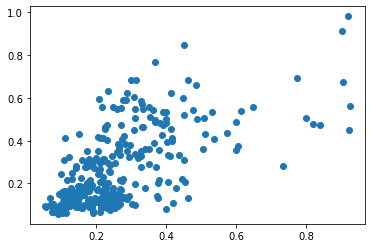

In [ ]:

plt.scatter(jsonDF['Box_norm_width'], jsonDF['Box_norm_height'])

### Find the optimum number of cluster for the given data shape by plotting the kmeans inertia vs number of cluster
The plot is shaped like an elbow , the optimal number of cluster is at the elbow of the plot.

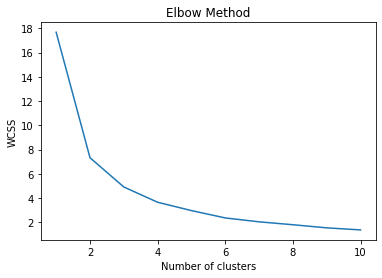

In [ ]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(feedTOKMeans)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Plot the cluster center for 5 clusters
Data is concentrated close to the first cluster

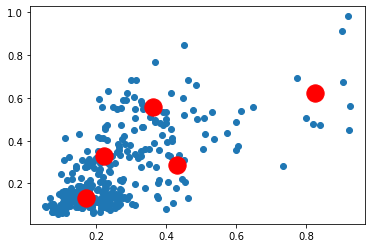

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(feedTOKMeans)

plt.scatter(feedTOKMeans[:,0], feedTOKMeans[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [ ]:
kmx = kmeans.cluster_centers_[:, 0]
kmy = kmeans.cluster_centers_[:, 1]
kmx

array([0.22257609, 0.43082609, 0.16964643, 0.82386345, 0.36318298])

### Calculate the Intersection Over Union for each cluster w.r.t a given coordinate and chose the cluster which has maximum IoU

In [ ]:

cluster = []
for i in range(len(jsonDF)):
    IoU = []
    for j in range(len(kmx)):
        minx = min(jsonDF['Box_norm_width'][i],kmx[j])
        miny = min(jsonDF['Box_norm_height'][i],kmy[j])
        maxx = max(jsonDF['Box_norm_width'][i],kmx[j])
        maxy = max(jsonDF['Box_norm_height'][i],kmy[j])
        
        IoU.append((min(jsonDF['Box_norm_width'][i],kmx[j])*min(jsonDF['Box_norm_height'][i],kmy[j]))/(max(jsonDF['Box_norm_width'][i],kmx[j])*max(jsonDF['Box_norm_height'][i],kmy[j])))
        #print(" bwid {} , kmx {} bhgt {} kmy {}".format(jsonDF['Box_norm_width'][i],kmx[j],jsonDF['Box_norm_height'][i],kmy[j]))
        #print("\n minx {} miny {} maxx {} maxy {} \n inter {} unin {} iou {}".format(minx , miny,maxx , maxy , min(jsonDF['Box_norm_width'][i],kmx[j])*min(jsonDF['Box_norm_height'][i],kmy[j]) ,(max(jsonDF['Box_norm_width'][i],kmx[j])*max(jsonDF['Box_norm_height'][i],kmy[j])) ))
    #print(" iou {} max{} indx {}".format(IoU , max(IoU) , IoU.index(max(IoU)) ))
    
    cluster.append(IoU.index(max(IoU)))
    
jsonDF["Cluster"] = cluster

### Store the cluster information in the dataframe

In [ ]:
jsonDF["Cluster_centers"] = [kmeans.cluster_centers_ for i in range(len(jsonDF))]

### Show the final dataframe

In [ ]:
jsonDF

### Save the dataframe 

In [ ]:
jsonDF.to_csv(filepath + 'S12_Assignment_Solution_cluster.csv', index= False)